## KAN RL

In [1]:
!pip install moviepy~=1.0.3 gymnasium pykan~=0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 10.4 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 55.0 MB/s eta 0:00:00:00:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=75a21a056c0a717c614730c14296780514b35f898c04430b6a679fba5726a5c0
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


## Models

100%|██████████| 26421880/26421880 [00:00<00:00, 83236240.86it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4995556.38it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 63327165.20it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8464240.29it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

State shape: torch.Size([1, 8, 8])
Label: tensor(5)
Feedback shape: torch.Size([1, 8, 8])


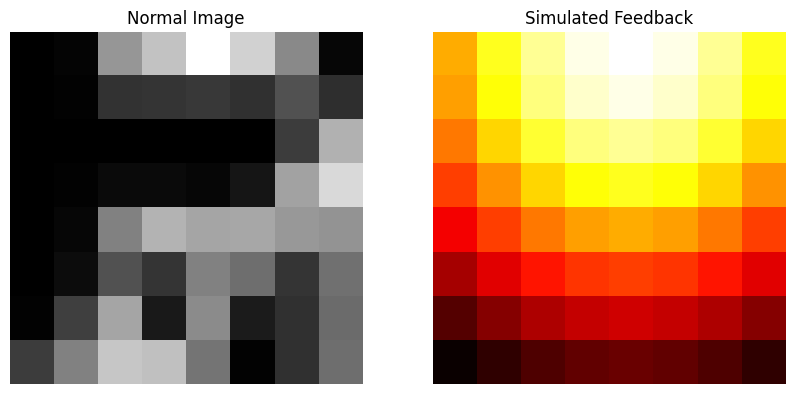

tensor(0.2725) tensor(1.)


In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py  for normalization values computation

class BenchmarkEnvironment:
    def __init__(self, dataset_name='MNIST', batch_size=128, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.num_channels = 1  # Force single channel for all datasets

        if dataset_name == 'MNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            self.dataset = datasets.MNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'FashionMNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR10':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Pad(4),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR10('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR100':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Pad(4),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR100('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'SVHN':
            self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)),
                #transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.SVHN('./data', split='train', download=True, transform=self.transform)

        elif dataset_name == 'KMNIST':
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.KMNIST('./data', train=True, download=True, transform=self.transform)

        else:
            raise ValueError(f"Dataset {dataset_name} is not supported.")


        self.loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback


    def generate_simulated_feedback(self, image_tensor):
        # If the image has 3 channels (RGB), average them into a single channel
        if image_tensor.shape[1] == 3:  # Check if there are 3 channels (RGB)
            image_np = image_tensor.mean(dim=1).squeeze().numpy()  # Average across channels
        else:  # For grayscale or single-channel images
            image_np = image_tensor.squeeze().numpy()

        # Normalize the image to [0, 1]
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        # Calculate the center of mass
        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape[-2:]))

        # Generate a Gaussian feedback mask based on the center of mass
        x, y = np.meshgrid(np.arange(image_np.shape[-1]), np.arange(image_np.shape[-2]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        # Normalize the feedback mask
        feedback = gaussian_mask / np.max(gaussian_mask)

        # Return the feedback as a tensor
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)

def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Check if the normal image has 3 channels (RGB)
    if normal_image_np.ndim == 3 and normal_image_np.shape[0] == 3:  # RGB image
        # Transpose to (height, width, channels) for imshow
        normal_image_np = normal_image_np.transpose(1, 2, 0)
        axes[0].imshow(normal_image_np)
    else:  # Grayscale image
        axes[0].imshow(normal_image_np, cmap='gray')
    
    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image (assumed to be single-channel, displayed with 'hot' colormap)
    axes[1].imshow(feedback_image_np, cmap='hot')
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()


# Example usage:
if __name__ == "__main__":
    env = BenchmarkEnvironment(dataset_name='FashionMNIST', batch_size=128, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())


In [3]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        # self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, input_shape[0], input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()            

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 1  # Specify the desired number of convolutional layers
num_filters = 2 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)
print(flat_zoom_X.shape)

FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)
torch.Size([1, 64])


In [4]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):
    

    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)



2024-11-01 16:22:08.768633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 16:22:08.768779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 16:22:08.906468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = BenchmarkEnvironment(dataset_name='FashionMNIST', batch_size=config["batch_size"], feedback_sigma=5.0)    #MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_SVHN_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])

              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())


          correct = 0
          total = 0
          with torch.no_grad():
                  # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
                  # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
                  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
                  # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
                  # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
              for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                             #split='test', download=True, transform=transforms.Compose([
                                                             #train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
                  #transforms.Grayscale(num_output_channels=1)
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])

                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent


In [6]:

# config = {
#     "batch_size": 128,
#     "n_epochs": 5,
#     "gamma": 0.8,
#     "learning_rate": 1e-3, # 0.0005
#     "weight_decay": 1e-4,
#     "width": 8,
#     "grid": 3,
#     "method": "KAN",  # "MLP", "KAN"
#     "seed": 0,
#     "input_size": 8 * 8, # number of features
#     "output_size": 10, # number of classes
#     "buffer_size": 100000,
#     "target_update": 10,
#     "warm_up_episodes": 2,
#     "num_filters": 4,
#     "num_conv_layers": 2,
#     "first_channel": 1, # (1,8,8)
#     "hidden_dim": 128,
#     "feature_selection": True,
#     "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
#     "initial_tau": 1.0, # positive float value

# }

# q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

In [7]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 1, 3, 5], input_shape=(1, 8, 8)):
#     # Determine the side length of the image
#     side_length = int(np.sqrt(probs_history[0].shape[1]))

#     fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#     for i, epoch in enumerate(epochs):
#         ax = axes[i // 2, i % 2]
#         if epoch < len(probs_history):
#             probs = probs_history[epoch].flatten()
#             if side_length ** 2 != probs.shape[0]:
#                 continue
#             probs_image = probs.reshape((side_length, side_length))
#             cax = ax.matshow(probs_image, cmap='viridis')
#             fig.colorbar(cax, ax=ax)
#             ax.set_title(f'Probabilities at Epoch {epoch}')
#         else:
#             ax.axis('off')

#     plt.tight_layout()
#     plt.show()

#     plt.figure(figsize=(10, 5))
#     plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
#     plt.xlabel('Epoch')
#     plt.ylabel('Feedback Cost')
#     plt.title('Evolution of Feedback Cost (MSE)')
#     plt.legend()
#     plt.show()


# plot_evolution(probs_history, feedback_cost_history)


# MLP

In [8]:
!pip install torchview

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)
64


MLP_SVHN_0_1730478151:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.06439555257654139
 Train accuracy:  0.10021321961620469 | 


MLP_SVHN_0_1730478151:   1%|          | 1/100 [00:04<07:44,  4.69s/it]

 Test accuracy:  0.2445

correct: 40 total: 469
loss: 0.07680759713975097
 Train accuracy:  0.08528784648187633 | 


MLP_SVHN_0_1730478151:   2%|▏         | 2/100 [00:09<07:48,  4.78s/it]

 Test accuracy:  0.3263

correct: 170 total: 469
loss: 0.0856580099206108
 Train accuracy:  0.3624733475479744 | 


MLP_SVHN_0_1730478151:   3%|▎         | 3/100 [00:14<07:46,  4.81s/it]

 Test accuracy:  0.3935

correct: 180 total: 469
loss: 0.09686806427835147
 Train accuracy:  0.3837953091684435 | 


MLP_SVHN_0_1730478151:   4%|▍         | 4/100 [00:19<07:50,  4.90s/it]

 Test accuracy:  0.4133

correct: 212 total: 469
loss: 0.1033456566840855
 Train accuracy:  0.4520255863539446 | 


MLP_SVHN_0_1730478151:   5%|▌         | 5/100 [00:24<07:59,  5.05s/it]

 Test accuracy:  0.4369

correct: 209 total: 469
loss: 0.1068935723129366
 Train accuracy:  0.44562899786780386 | 


MLP_SVHN_0_1730478151:   6%|▌         | 6/100 [00:30<08:27,  5.40s/it]

 Test accuracy:  0.4634

correct: 235 total: 469
loss: 0.11055964059921215
 Train accuracy:  0.5010660980810234 | 


MLP_SVHN_0_1730478151:   7%|▋         | 7/100 [00:36<08:29,  5.48s/it]

 Test accuracy:  0.4729

correct: 218 total: 469
loss: 0.11345195169769116
 Train accuracy:  0.464818763326226 | 


MLP_SVHN_0_1730478151:   8%|▊         | 8/100 [00:42<08:26,  5.51s/it]

 Test accuracy:  0.487

correct: 227 total: 469
loss: 0.11523132361392223
 Train accuracy:  0.4840085287846482 | 


MLP_SVHN_0_1730478151:   9%|▉         | 9/100 [00:47<08:24,  5.54s/it]

 Test accuracy:  0.5093

correct: 240 total: 469
loss: 0.116398251704824
 Train accuracy:  0.511727078891258 | 


MLP_SVHN_0_1730478151:  10%|█         | 10/100 [00:53<08:21,  5.57s/it]

 Test accuracy:  0.5001

correct: 227 total: 469
loss: 0.1184378454743672
 Train accuracy:  0.4840085287846482 | 


MLP_SVHN_0_1730478151:  11%|█         | 11/100 [00:59<08:21,  5.64s/it]

 Test accuracy:  0.514

correct: 229 total: 469
loss: 0.1193598679928129
 Train accuracy:  0.488272921108742 | 


MLP_SVHN_0_1730478151:  12%|█▏        | 12/100 [01:05<08:36,  5.87s/it]

 Test accuracy:  0.5204

correct: 235 total: 469
loss: 0.12116026177779952
 Train accuracy:  0.5010660980810234 | 


MLP_SVHN_0_1730478151:  13%|█▎        | 13/100 [01:11<08:33,  5.90s/it]

 Test accuracy:  0.5192

correct: 246 total: 469
loss: 0.12225831034722359
 Train accuracy:  0.5245202558635395 | 


MLP_SVHN_0_1730478151:  14%|█▍        | 14/100 [01:17<08:34,  5.98s/it]

 Test accuracy:  0.5232

correct: 242 total: 469
loss: 0.12210978728049854
 Train accuracy:  0.5159914712153518 | 


MLP_SVHN_0_1730478151:  15%|█▌        | 15/100 [01:23<08:34,  6.05s/it]

 Test accuracy:  0.5318

correct: 261 total: 469
loss: 0.1238030787946573
 Train accuracy:  0.5565031982942431 | 


MLP_SVHN_0_1730478151:  16%|█▌        | 16/100 [01:30<08:34,  6.12s/it]

 Test accuracy:  0.5357

correct: 255 total: 469
loss: 0.12449568610137968
 Train accuracy:  0.5437100213219617 | 


MLP_SVHN_0_1730478151:  17%|█▋        | 17/100 [01:36<08:37,  6.24s/it]

 Test accuracy:  0.5474

correct: 271 total: 469
loss: 0.12485045572715019
 Train accuracy:  0.5778251599147122 | 


MLP_SVHN_0_1730478151:  18%|█▊        | 18/100 [01:42<08:30,  6.22s/it]

 Test accuracy:  0.545

correct: 251 total: 469
loss: 0.12489386979959158
 Train accuracy:  0.535181236673774 | 


MLP_SVHN_0_1730478151:  19%|█▉        | 19/100 [01:49<08:25,  6.24s/it]

 Test accuracy:  0.5552

correct: 269 total: 469
loss: 0.1255700769327851
 Train accuracy:  0.5735607675906184 | 


MLP_SVHN_0_1730478151:  20%|██        | 20/100 [01:55<08:15,  6.19s/it]

 Test accuracy:  0.5551

correct: 252 total: 469
loss: 0.12627044650537372
 Train accuracy:  0.5373134328358209 | 


MLP_SVHN_0_1730478151:  21%|██        | 21/100 [02:01<08:03,  6.12s/it]

 Test accuracy:  0.5429

correct: 243 total: 469
loss: 0.12637291707273232
 Train accuracy:  0.5181236673773987 | 


MLP_SVHN_0_1730478151:  22%|██▏       | 22/100 [02:06<07:50,  6.03s/it]

 Test accuracy:  0.5563

correct: 261 total: 469
loss: 0.12777538962964055
 Train accuracy:  0.5565031982942431 | 


MLP_SVHN_0_1730478151:  23%|██▎       | 23/100 [02:12<07:38,  5.95s/it]

 Test accuracy:  0.5527

correct: 260 total: 469
loss: 0.12793682834931783
 Train accuracy:  0.5543710021321961 | 


MLP_SVHN_0_1730478151:  24%|██▍       | 24/100 [02:18<07:35,  6.00s/it]

 Test accuracy:  0.5685

correct: 260 total: 469
loss: 0.12849813775975566
 Train accuracy:  0.5543710021321961 | 


MLP_SVHN_0_1730478151:  25%|██▌       | 25/100 [02:25<07:34,  6.06s/it]

 Test accuracy:  0.5631

correct: 271 total: 469
loss: 0.12896842938432815
 Train accuracy:  0.5778251599147122 | 


MLP_SVHN_0_1730478151:  26%|██▌       | 26/100 [02:31<07:27,  6.04s/it]

 Test accuracy:  0.5659

correct: 275 total: 469
loss: 0.12898514602484226
 Train accuracy:  0.5863539445628998 | 


MLP_SVHN_0_1730478151:  27%|██▋       | 27/100 [02:37<07:20,  6.03s/it]

 Test accuracy:  0.5708

correct: 263 total: 469
loss: 0.13011624405124803
 Train accuracy:  0.5607675906183369 | 


MLP_SVHN_0_1730478151:  28%|██▊       | 28/100 [02:43<07:15,  6.05s/it]

 Test accuracy:  0.5658

correct: 286 total: 469
loss: 0.12916628925848617
 Train accuracy:  0.6098081023454158 | 


MLP_SVHN_0_1730478151:  29%|██▉       | 29/100 [02:49<07:07,  6.02s/it]

 Test accuracy:  0.5657

correct: 266 total: 469
loss: 0.1299478147647528
 Train accuracy:  0.5671641791044776 | 


MLP_SVHN_0_1730478151:  30%|███       | 30/100 [02:55<07:07,  6.11s/it]

 Test accuracy:  0.5746

correct: 266 total: 469
loss: 0.13070405682902347
 Train accuracy:  0.5671641791044776 | 


MLP_SVHN_0_1730478151:  31%|███       | 31/100 [03:01<07:01,  6.10s/it]

 Test accuracy:  0.5624

correct: 260 total: 469
loss: 0.13087388266251285
 Train accuracy:  0.5543710021321961 | 


MLP_SVHN_0_1730478151:  32%|███▏      | 32/100 [03:07<06:57,  6.14s/it]

 Test accuracy:  0.5673

correct: 271 total: 469
loss: 0.13032239305375737
 Train accuracy:  0.5778251599147122 | 


MLP_SVHN_0_1730478151:  33%|███▎      | 33/100 [03:14<06:59,  6.26s/it]

 Test accuracy:  0.5715

correct: 275 total: 469
loss: 0.131005256605555
 Train accuracy:  0.5863539445628998 | 


MLP_SVHN_0_1730478151:  34%|███▍      | 34/100 [03:20<06:54,  6.28s/it]

 Test accuracy:  0.5748

correct: 264 total: 469
loss: 0.1315515937486183
 Train accuracy:  0.5628997867803838 | 


MLP_SVHN_0_1730478151:  35%|███▌      | 35/100 [03:26<06:49,  6.30s/it]

 Test accuracy:  0.5884

correct: 264 total: 469
loss: 0.13131123666824307
 Train accuracy:  0.5628997867803838 | 


MLP_SVHN_0_1730478151:  36%|███▌      | 36/100 [03:33<06:42,  6.29s/it]

 Test accuracy:  0.5827

correct: 281 total: 469
loss: 0.13149493567343715
 Train accuracy:  0.5991471215351812 | 


MLP_SVHN_0_1730478151:  37%|███▋      | 37/100 [03:39<06:37,  6.30s/it]

 Test accuracy:  0.5832

correct: 282 total: 469
loss: 0.13144435520683015
 Train accuracy:  0.6012793176972282 | 


MLP_SVHN_0_1730478151:  38%|███▊      | 38/100 [03:46<06:34,  6.36s/it]

 Test accuracy:  0.5791

correct: 268 total: 469
loss: 0.13151123681302263
 Train accuracy:  0.5714285714285714 | 


MLP_SVHN_0_1730478151:  39%|███▉      | 39/100 [03:52<06:22,  6.28s/it]

 Test accuracy:  0.5814

correct: 280 total: 469
loss: 0.13097818208528733
 Train accuracy:  0.5970149253731343 | 


MLP_SVHN_0_1730478151:  40%|████      | 40/100 [03:58<06:14,  6.23s/it]

 Test accuracy:  0.583

correct: 263 total: 469
loss: 0.1317842220669108
 Train accuracy:  0.5607675906183369 | 


MLP_SVHN_0_1730478151:  41%|████      | 41/100 [04:04<06:05,  6.19s/it]

 Test accuracy:  0.5871

correct: 281 total: 469
loss: 0.13168589276736226
 Train accuracy:  0.5991471215351812 | 


MLP_SVHN_0_1730478151:  42%|████▏     | 42/100 [04:10<05:53,  6.09s/it]

 Test accuracy:  0.5754

correct: 286 total: 469
loss: 0.1325634497759947
 Train accuracy:  0.6098081023454158 | 


MLP_SVHN_0_1730478151:  43%|████▎     | 43/100 [04:16<05:44,  6.05s/it]

 Test accuracy:  0.5873

correct: 276 total: 469
loss: 0.13258153629074218
 Train accuracy:  0.5884861407249466 | 


MLP_SVHN_0_1730478151:  44%|████▍     | 44/100 [04:21<05:33,  5.95s/it]

 Test accuracy:  0.5874

correct: 273 total: 469
loss: 0.13282593198295342
 Train accuracy:  0.582089552238806 | 


MLP_SVHN_0_1730478151:  45%|████▌     | 45/100 [04:27<05:26,  5.94s/it]

 Test accuracy:  0.5771

correct: 270 total: 469
loss: 0.13297055180329503
 Train accuracy:  0.5756929637526652 | 


MLP_SVHN_0_1730478151:  46%|████▌     | 46/100 [04:33<05:22,  5.97s/it]

 Test accuracy:  0.5895

correct: 281 total: 469
loss: 0.13250871244142812
 Train accuracy:  0.5991471215351812 | 


MLP_SVHN_0_1730478151:  47%|████▋     | 47/100 [04:39<05:16,  5.97s/it]

 Test accuracy:  0.5899

correct: 267 total: 469
loss: 0.13402494908904217
 Train accuracy:  0.5692963752665245 | 


MLP_SVHN_0_1730478151:  48%|████▊     | 48/100 [04:46<05:14,  6.06s/it]

 Test accuracy:  0.584

correct: 274 total: 469
loss: 0.13324387217444905
 Train accuracy:  0.5842217484008528 | 


MLP_SVHN_0_1730478151:  49%|████▉     | 49/100 [04:52<05:10,  6.09s/it]

 Test accuracy:  0.5895

correct: 284 total: 469
loss: 0.13361420779467137
 Train accuracy:  0.605543710021322 | 


MLP_SVHN_0_1730478151:  50%|█████     | 50/100 [04:58<05:05,  6.11s/it]

 Test accuracy:  0.5863

correct: 278 total: 469
loss: 0.13412729739698012
 Train accuracy:  0.5927505330490405 | 


MLP_SVHN_0_1730478151:  51%|█████     | 51/100 [05:04<04:58,  6.10s/it]

 Test accuracy:  0.5865

correct: 282 total: 469
loss: 0.13304039983670596
 Train accuracy:  0.6012793176972282 | 


MLP_SVHN_0_1730478151:  52%|█████▏    | 52/100 [05:10<04:56,  6.17s/it]

 Test accuracy:  0.59

correct: 278 total: 469
loss: 0.13372288788877315
 Train accuracy:  0.5927505330490405 | 


MLP_SVHN_0_1730478151:  53%|█████▎    | 53/100 [05:17<04:53,  6.25s/it]

 Test accuracy:  0.583

correct: 277 total: 469
loss: 0.1332214044005886
 Train accuracy:  0.5906183368869936 | 


MLP_SVHN_0_1730478151:  54%|█████▍    | 54/100 [05:23<04:46,  6.23s/it]

 Test accuracy:  0.5933

correct: 282 total: 469
loss: 0.13395083689295662
 Train accuracy:  0.6012793176972282 | 


MLP_SVHN_0_1730478151:  55%|█████▌    | 55/100 [05:29<04:40,  6.22s/it]

 Test accuracy:  0.5966

correct: 293 total: 469
loss: 0.13374934942801114
 Train accuracy:  0.6247334754797441 | 


MLP_SVHN_0_1730478151:  56%|█████▌    | 56/100 [05:35<04:34,  6.24s/it]

 Test accuracy:  0.5897

correct: 262 total: 469
loss: 0.13374870492896038
 Train accuracy:  0.55863539445629 | 


MLP_SVHN_0_1730478151:  57%|█████▋    | 57/100 [05:42<04:28,  6.23s/it]

 Test accuracy:  0.5855

correct: 285 total: 469
loss: 0.13419317153852378
 Train accuracy:  0.6076759061833689 | 


MLP_SVHN_0_1730478151:  58%|█████▊    | 58/100 [05:48<04:26,  6.35s/it]

 Test accuracy:  0.5962

correct: 274 total: 469
loss: 0.1342818965154416
 Train accuracy:  0.5842217484008528 | 


MLP_SVHN_0_1730478151:  59%|█████▉    | 59/100 [05:55<04:20,  6.35s/it]

 Test accuracy:  0.5842

correct: 267 total: 469
loss: 0.1348557222658383
 Train accuracy:  0.5692963752665245 | 


MLP_SVHN_0_1730478151:  60%|██████    | 60/100 [06:01<04:13,  6.34s/it]

 Test accuracy:  0.5824

correct: 283 total: 469
loss: 0.1341084327969724
 Train accuracy:  0.603411513859275 | 


MLP_SVHN_0_1730478151:  61%|██████    | 61/100 [06:07<04:07,  6.35s/it]

 Test accuracy:  0.5859

correct: 284 total: 469
loss: 0.13462026560230295
 Train accuracy:  0.605543710021322 | 


MLP_SVHN_0_1730478151:  62%|██████▏   | 62/100 [06:14<04:02,  6.38s/it]

 Test accuracy:  0.5911

correct: 274 total: 469
loss: 0.13439645954985607
 Train accuracy:  0.5842217484008528 | 


MLP_SVHN_0_1730478151:  63%|██████▎   | 63/100 [06:20<03:57,  6.42s/it]

 Test accuracy:  0.5917

correct: 291 total: 469
loss: 0.1346779392122714
 Train accuracy:  0.6204690831556503 | 


MLP_SVHN_0_1730478151:  64%|██████▍   | 64/100 [06:27<03:54,  6.50s/it]

 Test accuracy:  0.5878

correct: 280 total: 469
loss: 0.13448987361083406
 Train accuracy:  0.5970149253731343 | 


MLP_SVHN_0_1730478151:  65%|██████▌   | 65/100 [06:33<03:47,  6.49s/it]

 Test accuracy:  0.5972

correct: 275 total: 469
loss: 0.1346805179710073
 Train accuracy:  0.5863539445628998 | 


MLP_SVHN_0_1730478151:  66%|██████▌   | 66/100 [06:40<03:40,  6.48s/it]

 Test accuracy:  0.5985

correct: 290 total: 469
loss: 0.13444592022120572
 Train accuracy:  0.6183368869936035 | 


MLP_SVHN_0_1730478151:  67%|██████▋   | 67/100 [06:46<03:34,  6.50s/it]

 Test accuracy:  0.59

correct: 279 total: 469
loss: 0.13563940861522517
 Train accuracy:  0.5948827292110874 | 


MLP_SVHN_0_1730478151:  68%|██████▊   | 68/100 [06:53<03:27,  6.47s/it]

 Test accuracy:  0.597

correct: 275 total: 469
loss: 0.13447525743037653
 Train accuracy:  0.5863539445628998 | 


MLP_SVHN_0_1730478151:  69%|██████▉   | 69/100 [06:59<03:21,  6.49s/it]

 Test accuracy:  0.592

correct: 300 total: 469
loss: 0.13480279913970403
 Train accuracy:  0.6396588486140725 | 


MLP_SVHN_0_1730478151:  70%|███████   | 70/100 [07:06<03:15,  6.51s/it]

 Test accuracy:  0.5923

correct: 265 total: 469
loss: 0.13362262288390447
 Train accuracy:  0.5650319829424307 | 


MLP_SVHN_0_1730478151:  71%|███████   | 71/100 [07:12<03:08,  6.49s/it]

 Test accuracy:  0.5885

correct: 290 total: 469
loss: 0.13465586021892043
 Train accuracy:  0.6183368869936035 | 


MLP_SVHN_0_1730478151:  72%|███████▏  | 72/100 [07:19<03:01,  6.49s/it]

 Test accuracy:  0.5965

correct: 285 total: 469
loss: 0.1351303876653663
 Train accuracy:  0.6076759061833689 | 


MLP_SVHN_0_1730478151:  73%|███████▎  | 73/100 [07:25<02:56,  6.55s/it]

 Test accuracy:  0.5961

correct: 275 total: 469
loss: 0.13459808014031413
 Train accuracy:  0.5863539445628998 | 


MLP_SVHN_0_1730478151:  74%|███████▍  | 74/100 [07:32<02:50,  6.56s/it]

 Test accuracy:  0.5936

correct: 271 total: 469
loss: 0.13519383261579948
 Train accuracy:  0.5778251599147122 | 


MLP_SVHN_0_1730478151:  75%|███████▌  | 75/100 [07:39<02:43,  6.56s/it]

 Test accuracy:  0.5992

correct: 286 total: 469
loss: 0.13474066185353917
 Train accuracy:  0.6098081023454158 | 


MLP_SVHN_0_1730478151:  76%|███████▌  | 76/100 [07:45<02:37,  6.55s/it]

 Test accuracy:  0.5889

correct: 293 total: 469
loss: 0.1351166486041124
 Train accuracy:  0.6247334754797441 | 


MLP_SVHN_0_1730478151:  77%|███████▋  | 77/100 [07:52<02:30,  6.53s/it]

 Test accuracy:  0.592

correct: 269 total: 469
loss: 0.13434136601716978
 Train accuracy:  0.5735607675906184 | 


MLP_SVHN_0_1730478151:  78%|███████▊  | 78/100 [07:58<02:23,  6.51s/it]

 Test accuracy:  0.5966

correct: 280 total: 469
loss: 0.13517399297467173
 Train accuracy:  0.5970149253731343 | 


MLP_SVHN_0_1730478151:  79%|███████▉  | 79/100 [08:04<02:15,  6.47s/it]

 Test accuracy:  0.5959

correct: 281 total: 469
loss: 0.13529447305685421
 Train accuracy:  0.5991471215351812 | 


MLP_SVHN_0_1730478151:  80%|████████  | 80/100 [08:11<02:09,  6.45s/it]

 Test accuracy:  0.5923

correct: 291 total: 469
loss: 0.1351711643434791
 Train accuracy:  0.6204690831556503 | 


MLP_SVHN_0_1730478151:  81%|████████  | 81/100 [08:17<02:02,  6.44s/it]

 Test accuracy:  0.5936

correct: 264 total: 469
loss: 0.13585576384878362
 Train accuracy:  0.5628997867803838 | 


MLP_SVHN_0_1730478151:  82%|████████▏ | 82/100 [08:24<01:55,  6.42s/it]

 Test accuracy:  0.5882

correct: 270 total: 469
loss: 0.13519514788950937
 Train accuracy:  0.5756929637526652 | 


MLP_SVHN_0_1730478151:  83%|████████▎ | 83/100 [08:30<01:49,  6.46s/it]

 Test accuracy:  0.5934

correct: 267 total: 469
loss: 0.13537634365848386
 Train accuracy:  0.5692963752665245 | 


MLP_SVHN_0_1730478151:  84%|████████▍ | 84/100 [08:37<01:43,  6.46s/it]

 Test accuracy:  0.5984

correct: 288 total: 469
loss: 0.1359569388253094
 Train accuracy:  0.6140724946695096 | 


MLP_SVHN_0_1730478151:  85%|████████▌ | 85/100 [08:43<01:37,  6.49s/it]

 Test accuracy:  0.6007

correct: 272 total: 469
loss: 0.13569474361662162
 Train accuracy:  0.579957356076759 | 


MLP_SVHN_0_1730478151:  86%|████████▌ | 86/100 [08:50<01:30,  6.48s/it]

 Test accuracy:  0.5965

correct: 283 total: 469
loss: 0.13535380644648315
 Train accuracy:  0.603411513859275 | 


MLP_SVHN_0_1730478151:  87%|████████▋ | 87/100 [08:56<01:24,  6.50s/it]

 Test accuracy:  0.5989

correct: 269 total: 469
loss: 0.13520450548513102
 Train accuracy:  0.5735607675906184 | 


MLP_SVHN_0_1730478151:  88%|████████▊ | 88/100 [09:03<01:19,  6.60s/it]

 Test accuracy:  0.5953

correct: 273 total: 469
loss: 0.13564137289963807
 Train accuracy:  0.582089552238806 | 


MLP_SVHN_0_1730478151:  89%|████████▉ | 89/100 [09:10<01:13,  6.71s/it]

 Test accuracy:  0.5891

correct: 279 total: 469
loss: 0.13560025965862438
 Train accuracy:  0.5948827292110874 | 


MLP_SVHN_0_1730478151:  90%|█████████ | 90/100 [09:17<01:06,  6.67s/it]

 Test accuracy:  0.5993

correct: 290 total: 469
loss: 0.1365967410078435
 Train accuracy:  0.6183368869936035 | 


MLP_SVHN_0_1730478151:  91%|█████████ | 91/100 [09:23<00:59,  6.66s/it]

 Test accuracy:  0.5933

correct: 283 total: 469
loss: 0.13588612594965424
 Train accuracy:  0.603411513859275 | 


MLP_SVHN_0_1730478151:  92%|█████████▏| 92/100 [09:30<00:53,  6.67s/it]

 Test accuracy:  0.6012

correct: 275 total: 469
loss: 0.1355359982897732
 Train accuracy:  0.5863539445628998 | 


MLP_SVHN_0_1730478151:  93%|█████████▎| 93/100 [09:37<00:47,  6.73s/it]

 Test accuracy:  0.6071

correct: 288 total: 469
loss: 0.13614493452790957
 Train accuracy:  0.6140724946695096 | 


MLP_SVHN_0_1730478151:  94%|█████████▍| 94/100 [09:43<00:40,  6.71s/it]

 Test accuracy:  0.6026

correct: 293 total: 469
loss: 0.13612411790755766
 Train accuracy:  0.6247334754797441 | 


MLP_SVHN_0_1730478151:  95%|█████████▌| 95/100 [09:51<00:34,  6.83s/it]

 Test accuracy:  0.5937

correct: 291 total: 469
loss: 0.13554786839909644
 Train accuracy:  0.6204690831556503 | 


MLP_SVHN_0_1730478151:  96%|█████████▌| 96/100 [09:57<00:27,  6.79s/it]

 Test accuracy:  0.5999

correct: 298 total: 469
loss: 0.13637338883714126
 Train accuracy:  0.6353944562899787 | 


MLP_SVHN_0_1730478151:  97%|█████████▋| 97/100 [10:04<00:20,  6.78s/it]

 Test accuracy:  0.6018

correct: 269 total: 469
loss: 0.13517737542706004
 Train accuracy:  0.5735607675906184 | 


MLP_SVHN_0_1730478151:  98%|█████████▊| 98/100 [10:11<00:13,  6.79s/it]

 Test accuracy:  0.5962

correct: 276 total: 469
loss: 0.13589210746321342
 Train accuracy:  0.5884861407249466 | 


MLP_SVHN_0_1730478151:  99%|█████████▉| 99/100 [10:18<00:06,  6.77s/it]

 Test accuracy:  0.6035

correct: 277 total: 469
loss: 0.1361749994792918
 Train accuracy:  0.5906183368869936 | 


MLP_SVHN_0_1730478151: 100%|██████████| 100/100 [10:24<00:00,  6.25s/it]

 Test accuracy:  0.5945


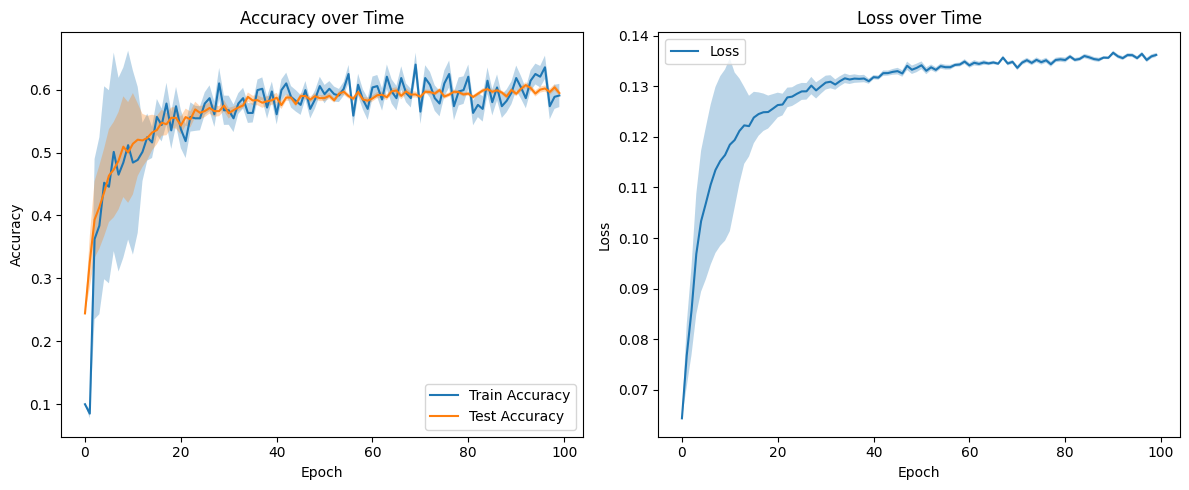

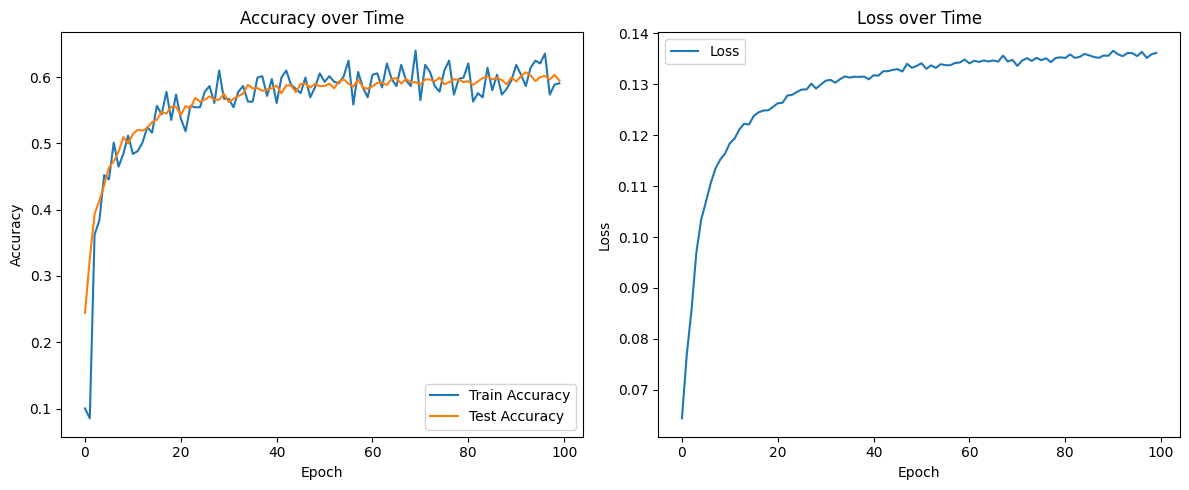

Final Train Accuracy: 0.59 ± 0.02
Final Test Accuracy: 0.59 ± 0.00


In [9]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 32,
    "grid": 3,
    "method": "MLP",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 8, # 4, 8
    "num_conv_layers": 3, # 2, 3
    "first_channel": 1, # (1,8,8) or (3,8,8)
    "hidden_dim": 128,
    "feature_selection": False,
    "distribution": "beta", # "bernoulli", "gumbel_softmax", "gaussian", "beta", "dirichlet", "multinomial", "cauchy", "laplace", "uniform"
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

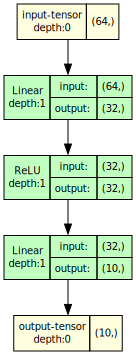

In [10]:
## MLP architecture
import torchvision
from torchview import draw_graph

model_graph = draw_graph(q_network, input_size=(8 * 8,), expand_nested=True)
model_graph.visual_graph

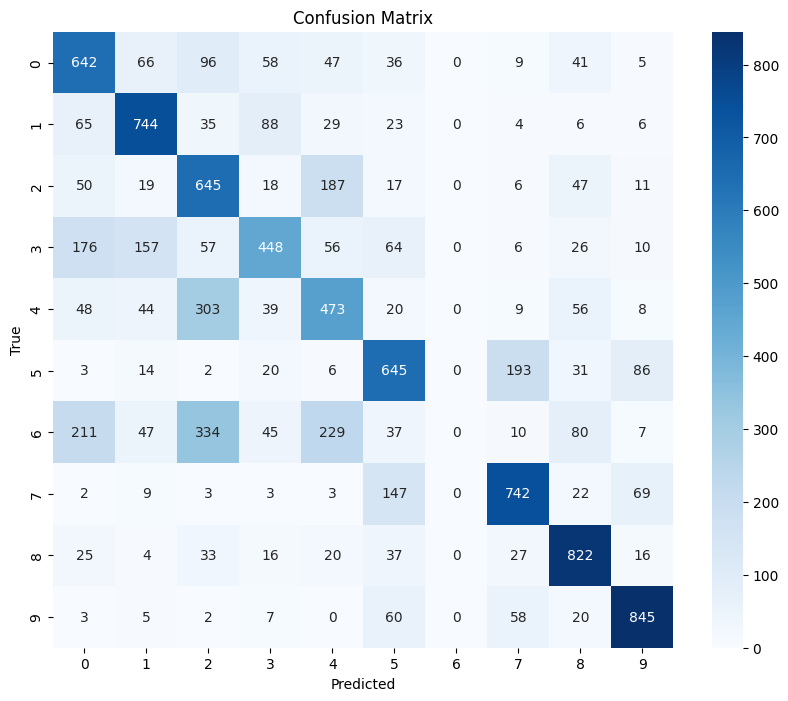

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
      # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
      # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
      # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
    for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                    #split='test', download=True, transform=transforms.Compose([
                                                 #train=False, download=True, transform=transforms.Compose([
      transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      #transforms.Grayscale(num_output_channels=1)
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)
        
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [12]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.64      0.58      1000
           1       0.67      0.74      0.71      1000
           2       0.43      0.65      0.51      1000
           3       0.60      0.45      0.51      1000
           4       0.45      0.47      0.46      1000
           5       0.59      0.65      0.62      1000
           6       0.00      0.00      0.00      1000
           7       0.70      0.74      0.72      1000
           8       0.71      0.82      0.76      1000
           9       0.79      0.84      0.82      1000

    accuracy                           0.60     10000
   macro avg       0.55      0.60      0.57     10000
weighted avg       0.55      0.60      0.57     10000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


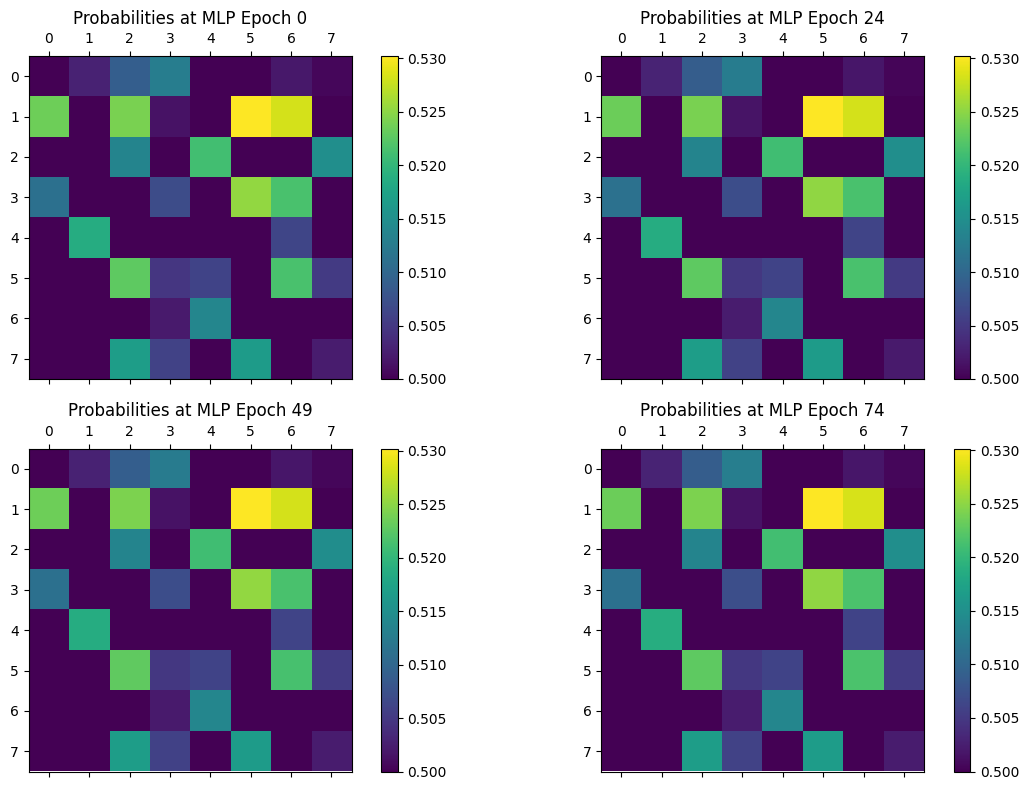

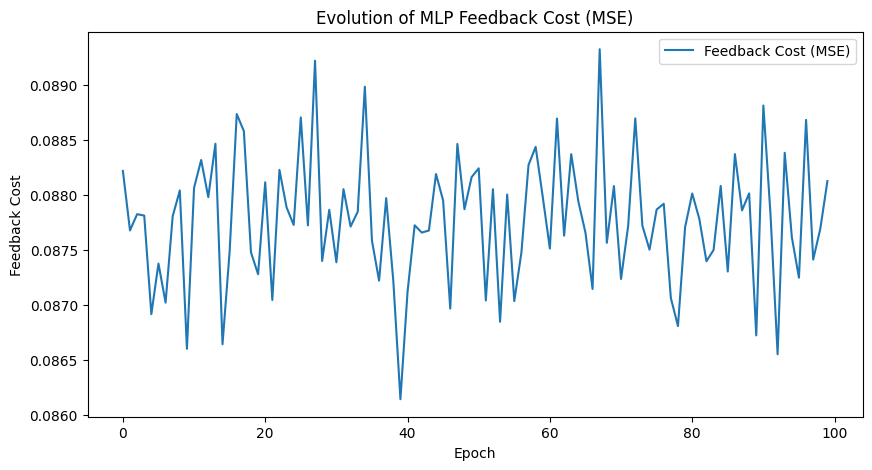

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 24, 49, 74], input_shape=(1, 8, 8)):
    # Determine the side length of the image
    side_length = int(np.sqrt(probs_history[0].shape[1]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        if epoch < len(probs_history):
            probs = probs_history[epoch].flatten()
            if side_length ** 2 != probs.shape[0]:
                continue
            probs_image = probs.reshape((side_length, side_length))
            cax = ax.matshow(probs_image, cmap='viridis')
            fig.colorbar(cax, ax=ax)
            ax.set_title(f'Probabilities at MLP Epoch {epoch}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Feedback Cost')
    plt.title('Evolution of MLP Feedback Cost (MSE)')
    plt.legend()
    plt.show()


plot_evolution(probs_history, feedback_cost_history)


In [14]:
import gc
gc.collect()

56394

# KAN

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
)
64


KAN_SVHN_0_1730478787:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.0662707940442984
 Train accuracy:  0.10021321961620469 | 


KAN_SVHN_0_1730478787:   1%|          | 1/100 [01:52<3:06:01, 112.74s/it]

 Test accuracy:  0.1287

correct: 40 total: 469
loss: 0.053881726420319666
 Train accuracy:  0.08528784648187633 | 


KAN_SVHN_0_1730478787:   2%|▏         | 2/100 [04:28<3:45:25, 138.01s/it]

 Test accuracy:  0.2466

correct: 106 total: 469
loss: 0.054080689266355814
 Train accuracy:  0.2260127931769723 | 


KAN_SVHN_0_1730478787:   3%|▎         | 3/100 [07:23<4:10:18, 154.83s/it]

 Test accuracy:  0.2303

correct: 107 total: 469
loss: 0.05808330047677066
 Train accuracy:  0.2281449893390192 | 


KAN_SVHN_0_1730478787:   4%|▍         | 4/100 [10:17<4:19:49, 162.39s/it]

 Test accuracy:  0.2244

correct: 106 total: 469
loss: 0.06141038370062547
 Train accuracy:  0.2260127931769723 | 


KAN_SVHN_0_1730478787:   5%|▌         | 5/100 [13:12<4:24:42, 167.19s/it]

 Test accuracy:  0.215

correct: 97 total: 469
loss: 0.06713426427673429
 Train accuracy:  0.2068230277185501 | 


KAN_SVHN_0_1730478787:   6%|▌         | 6/100 [16:08<4:26:36, 170.17s/it]

 Test accuracy:  0.2089

correct: 115 total: 469
loss: 0.06909743995109854
 Train accuracy:  0.24520255863539445 | 


KAN_SVHN_0_1730478787:   7%|▋         | 7/100 [19:06<4:27:26, 172.54s/it]

 Test accuracy:  0.2194

correct: 88 total: 469
loss: 0.07860514524776036
 Train accuracy:  0.18763326226012794 | 


KAN_SVHN_0_1730478787:   8%|▊         | 8/100 [22:04<4:27:14, 174.28s/it]

 Test accuracy:  0.2256

correct: 84 total: 469
loss: 0.08078526628455882
 Train accuracy:  0.1791044776119403 | 


KAN_SVHN_0_1730478787:   9%|▉         | 9/100 [25:02<4:26:01, 175.40s/it]

 Test accuracy:  0.2279

correct: 107 total: 469
loss: 0.0807219267939962
 Train accuracy:  0.2281449893390192 | 


KAN_SVHN_0_1730478787:  10%|█         | 10/100 [27:59<4:24:02, 176.03s/it]

 Test accuracy:  0.2379

correct: 118 total: 469
loss: 0.08113738416290994
 Train accuracy:  0.2515991471215352 | 


KAN_SVHN_0_1730478787:  11%|█         | 11/100 [30:57<4:22:02, 176.66s/it]

 Test accuracy:  0.2463

correct: 106 total: 469
loss: 0.0816761091160876
 Train accuracy:  0.2260127931769723 | 


KAN_SVHN_0_1730478787:  12%|█▏        | 12/100 [33:56<4:20:05, 177.33s/it]

 Test accuracy:  0.2481

correct: 119 total: 469
loss: 0.08522501307478084
 Train accuracy:  0.2537313432835821 | 


KAN_SVHN_0_1730478787:  13%|█▎        | 13/100 [36:55<4:17:59, 177.93s/it]

 Test accuracy:  0.2548

correct: 136 total: 469
loss: 0.08736297842472601
 Train accuracy:  0.2899786780383795 | 


KAN_SVHN_0_1730478787:  14%|█▍        | 14/100 [39:55<4:15:49, 178.48s/it]

 Test accuracy:  0.2681

correct: 131 total: 469
loss: 0.0873754508793354
 Train accuracy:  0.279317697228145 | 


KAN_SVHN_0_1730478787:  15%|█▌        | 15/100 [42:55<4:13:37, 179.03s/it]

 Test accuracy:  0.2775

correct: 141 total: 469
loss: 0.08830149921336408
 Train accuracy:  0.3006396588486141 | 


KAN_SVHN_0_1730478787:  16%|█▌        | 16/100 [45:56<4:11:21, 179.55s/it]

 Test accuracy:  0.2905

correct: 126 total: 469
loss: 0.09133252704829804
 Train accuracy:  0.26865671641791045 | 


KAN_SVHN_0_1730478787:  17%|█▋        | 17/100 [49:01<4:10:34, 181.13s/it]

 Test accuracy:  0.2945

correct: 148 total: 469
loss: 0.09356078746984763
 Train accuracy:  0.31556503198294245 | 


KAN_SVHN_0_1730478787:  18%|█▊        | 18/100 [52:05<4:08:45, 182.01s/it]

 Test accuracy:  0.3105

correct: 144 total: 469
loss: 0.0949729257491606
 Train accuracy:  0.3070362473347548 | 


KAN_SVHN_0_1730478787:  19%|█▉        | 19/100 [55:10<4:06:54, 182.90s/it]

 Test accuracy:  0.3212

correct: 136 total: 469
loss: 0.09944063941362316
 Train accuracy:  0.2899786780383795 | 


KAN_SVHN_0_1730478787:  20%|██        | 20/100 [58:14<4:04:13, 183.17s/it]

 Test accuracy:  0.2908

correct: 155 total: 469
loss: 0.09998280269060053
 Train accuracy:  0.3304904051172708 | 


KAN_SVHN_0_1730478787:  21%|██        | 21/100 [1:01:18<4:01:33, 183.47s/it]

 Test accuracy:  0.3266

correct: 167 total: 469
loss: 0.09925919048376937
 Train accuracy:  0.35607675906183367 | 


KAN_SVHN_0_1730478787:  22%|██▏       | 22/100 [1:04:21<3:58:25, 183.40s/it]

 Test accuracy:  0.3528

correct: 188 total: 469
loss: 0.10176734054393606
 Train accuracy:  0.40085287846481876 | 


KAN_SVHN_0_1730478787:  23%|██▎       | 23/100 [1:07:25<3:55:29, 183.50s/it]

 Test accuracy:  0.3622

correct: 162 total: 469
loss: 0.10091349231535947
 Train accuracy:  0.34541577825159914 | 


KAN_SVHN_0_1730478787:  24%|██▍       | 24/100 [1:10:29<3:52:45, 183.76s/it]

 Test accuracy:  0.3925

correct: 183 total: 469
loss: 0.10103745053190666
 Train accuracy:  0.39019189765458423 | 


KAN_SVHN_0_1730478787:  25%|██▌       | 25/100 [1:13:34<3:49:57, 183.97s/it]

 Test accuracy:  0.404

correct: 183 total: 469
loss: 0.1030649682288485
 Train accuracy:  0.39019189765458423 | 


KAN_SVHN_0_1730478787:  26%|██▌       | 26/100 [1:17:39<4:09:24, 202.22s/it]

 Test accuracy:  0.4717

correct: 242 total: 469
loss: 0.10317030313935106
 Train accuracy:  0.5159914712153518 | 


KAN_SVHN_0_1730478787:  27%|██▋       | 27/100 [1:20:45<4:00:20, 197.55s/it]

 Test accuracy:  0.5162

correct: 237 total: 469
loss: 0.10192153566300488
 Train accuracy:  0.5053304904051172 | 


KAN_SVHN_0_1730478787:  28%|██▊       | 28/100 [1:23:51<3:52:47, 193.99s/it]

 Test accuracy:  0.5064

correct: 254 total: 469
loss: 0.10038993502857843
 Train accuracy:  0.5415778251599147 | 


KAN_SVHN_0_1730478787:  29%|██▉       | 29/100 [1:26:58<3:47:04, 191.90s/it]

 Test accuracy:  0.5509

correct: 269 total: 469
loss: 0.10055325850685522
 Train accuracy:  0.5735607675906184 | 


KAN_SVHN_0_1730478787:  30%|███       | 30/100 [1:30:12<3:44:28, 192.40s/it]

 Test accuracy:  0.5466

correct: 261 total: 469
loss: 0.10033256544677942
 Train accuracy:  0.5565031982942431 | 


KAN_SVHN_0_1730478787:  31%|███       | 31/100 [1:33:19<3:39:43, 191.06s/it]

 Test accuracy:  0.5525

correct: 266 total: 469
loss: 0.1010139184529339
 Train accuracy:  0.5671641791044776 | 


KAN_SVHN_0_1730478787:  32%|███▏      | 32/100 [1:36:27<3:35:21, 190.02s/it]

 Test accuracy:  0.5762

correct: 265 total: 469
loss: 0.1000925627535086
 Train accuracy:  0.5650319829424307 | 


KAN_SVHN_0_1730478787:  33%|███▎      | 33/100 [1:39:35<3:31:25, 189.33s/it]

 Test accuracy:  0.5758

correct: 272 total: 469
loss: 0.10057781808284809
 Train accuracy:  0.579957356076759 | 


KAN_SVHN_0_1730478787:  34%|███▍      | 34/100 [1:42:44<3:28:05, 189.17s/it]

 Test accuracy:  0.5849

correct: 281 total: 469
loss: 0.10077090321509823
 Train accuracy:  0.5991471215351812 | 


KAN_SVHN_0_1730478787:  35%|███▌      | 35/100 [1:45:52<3:24:36, 188.86s/it]

 Test accuracy:  0.5825

correct: 265 total: 469
loss: 0.10091858906850124
 Train accuracy:  0.5650319829424307 | 


KAN_SVHN_0_1730478787:  36%|███▌      | 36/100 [1:49:01<3:21:27, 188.86s/it]

 Test accuracy:  0.5937

correct: 285 total: 469
loss: 0.10076247937262439
 Train accuracy:  0.6076759061833689 | 


KAN_SVHN_0_1730478787:  37%|███▋      | 37/100 [1:52:09<3:18:05, 188.67s/it]

 Test accuracy:  0.5788

correct: 284 total: 469
loss: 0.1013230720499177
 Train accuracy:  0.605543710021322 | 


KAN_SVHN_0_1730478787:  38%|███▊      | 38/100 [1:55:18<3:15:03, 188.76s/it]

 Test accuracy:  0.5796

correct: 276 total: 469
loss: 0.10195227041999415
 Train accuracy:  0.5884861407249466 | 


KAN_SVHN_0_1730478787:  39%|███▉      | 39/100 [1:58:27<3:12:00, 188.87s/it]

 Test accuracy:  0.5939

correct: 304 total: 469
loss: 0.10213674882899469
 Train accuracy:  0.6481876332622601 | 


KAN_SVHN_0_1730478787:  40%|████      | 40/100 [2:01:37<3:09:12, 189.21s/it]

 Test accuracy:  0.595

correct: 285 total: 469
loss: 0.10283162508374338
 Train accuracy:  0.6076759061833689 | 


KAN_SVHN_0_1730478787:  41%|████      | 41/100 [2:04:46<3:05:59, 189.15s/it]

 Test accuracy:  0.6104

correct: 292 total: 469
loss: 0.10344711524337086
 Train accuracy:  0.6226012793176973 | 


KAN_SVHN_0_1730478787:  42%|████▏     | 42/100 [2:07:54<3:02:33, 188.85s/it]

 Test accuracy:  0.6024

correct: 294 total: 469
loss: 0.10445592533360158
 Train accuracy:  0.6268656716417911 | 


KAN_SVHN_0_1730478787:  43%|████▎     | 43/100 [2:11:02<2:59:09, 188.60s/it]

 Test accuracy:  0.6014

correct: 282 total: 469
loss: 0.10362101908622266
 Train accuracy:  0.6012793176972282 | 


KAN_SVHN_0_1730478787:  44%|████▍     | 44/100 [2:14:10<2:55:53, 188.45s/it]

 Test accuracy:  0.6142

correct: 285 total: 469
loss: 0.10454865748376481
 Train accuracy:  0.6076759061833689 | 


KAN_SVHN_0_1730478787:  45%|████▌     | 45/100 [2:17:19<2:52:47, 188.49s/it]

 Test accuracy:  0.61

correct: 294 total: 469
loss: 0.10478776000710184
 Train accuracy:  0.6268656716417911 | 


KAN_SVHN_0_1730478787:  46%|████▌     | 46/100 [2:20:27<2:49:31, 188.37s/it]

 Test accuracy:  0.6142

correct: 286 total: 469
loss: 0.10540119164597506
 Train accuracy:  0.6098081023454158 | 


KAN_SVHN_0_1730478787:  47%|████▋     | 47/100 [2:23:34<2:46:09, 188.11s/it]

 Test accuracy:  0.6186

correct: 266 total: 469
loss: 0.10575026785259817
 Train accuracy:  0.5671641791044776 | 


KAN_SVHN_0_1730478787:  48%|████▊     | 48/100 [2:26:42<2:42:53, 187.95s/it]

 Test accuracy:  0.6091

correct: 309 total: 469
loss: 0.1054013282505434
 Train accuracy:  0.6588486140724946 | 


KAN_SVHN_0_1730478787:  49%|████▉     | 49/100 [2:29:50<2:39:41, 187.86s/it]

 Test accuracy:  0.6168

correct: 297 total: 469
loss: 0.10650678212518122
 Train accuracy:  0.6332622601279317 | 


KAN_SVHN_0_1730478787:  50%|█████     | 50/100 [2:32:57<2:36:27, 187.76s/it]

 Test accuracy:  0.6157

correct: 300 total: 469
loss: 0.1069747755713046
 Train accuracy:  0.6396588486140725 | 


KAN_SVHN_0_1730478787:  51%|█████     | 51/100 [2:36:05<2:33:23, 187.83s/it]

 Test accuracy:  0.6137

correct: 285 total: 469
loss: 0.10683590372297555
 Train accuracy:  0.6076759061833689 | 


KAN_SVHN_0_1730478787:  52%|█████▏    | 52/100 [2:39:14<2:30:26, 188.05s/it]

 Test accuracy:  0.6067

correct: 298 total: 469
loss: 0.10746683987346031
 Train accuracy:  0.6353944562899787 | 


KAN_SVHN_0_1730478787:  53%|█████▎    | 53/100 [2:42:21<2:27:15, 187.98s/it]

 Test accuracy:  0.6179

correct: 279 total: 469
loss: 0.10698479437815354
 Train accuracy:  0.5948827292110874 | 


KAN_SVHN_0_1730478787:  54%|█████▍    | 54/100 [2:45:31<2:24:24, 188.35s/it]

 Test accuracy:  0.6235

correct: 289 total: 469
loss: 0.10782847637687919
 Train accuracy:  0.6162046908315565 | 


KAN_SVHN_0_1730478787:  55%|█████▌    | 55/100 [2:48:38<2:21:07, 188.17s/it]

 Test accuracy:  0.6234

correct: 282 total: 469
loss: 0.10799666424232252
 Train accuracy:  0.6012793176972282 | 


KAN_SVHN_0_1730478787:  56%|█████▌    | 56/100 [2:51:46<2:17:55, 188.08s/it]

 Test accuracy:  0.6221

correct: 288 total: 469
loss: 0.10873584759070166
 Train accuracy:  0.6140724946695096 | 


KAN_SVHN_0_1730478787:  57%|█████▋    | 57/100 [2:54:55<2:14:52, 188.19s/it]

 Test accuracy:  0.6138

correct: 298 total: 469
loss: 0.10894811439361654
 Train accuracy:  0.6353944562899787 | 


KAN_SVHN_0_1730478787:  58%|█████▊    | 58/100 [2:58:03<2:11:49, 188.32s/it]

 Test accuracy:  0.6246

correct: 286 total: 469
loss: 0.1097012140126879
 Train accuracy:  0.6098081023454158 | 


KAN_SVHN_0_1730478787:  59%|█████▉    | 59/100 [3:01:12<2:08:39, 188.29s/it]

 Test accuracy:  0.6278

correct: 277 total: 469
loss: 0.10998112908495006
 Train accuracy:  0.5906183368869936 | 


KAN_SVHN_0_1730478787:  60%|██████    | 60/100 [3:04:21<2:05:43, 188.60s/it]

 Test accuracy:  0.6281

correct: 298 total: 469
loss: 0.1095660753023904
 Train accuracy:  0.6353944562899787 | 


KAN_SVHN_0_1730478787:  61%|██████    | 61/100 [3:07:30<2:02:41, 188.75s/it]

 Test accuracy:  0.6257

correct: 302 total: 469
loss: 0.11060593164424652
 Train accuracy:  0.6439232409381663 | 


KAN_SVHN_0_1730478787:  62%|██████▏   | 62/100 [3:10:39<1:59:40, 188.96s/it]

 Test accuracy:  0.6193

correct: 297 total: 469
loss: 0.1096758515691198
 Train accuracy:  0.6332622601279317 | 


KAN_SVHN_0_1730478787:  63%|██████▎   | 63/100 [3:13:49<1:56:34, 189.05s/it]

 Test accuracy:  0.6264

correct: 303 total: 469
loss: 0.11115972421316704
 Train accuracy:  0.6460554371002132 | 


KAN_SVHN_0_1730478787:  64%|██████▍   | 64/100 [3:16:57<1:53:20, 188.91s/it]

 Test accuracy:  0.6286

correct: 290 total: 469
loss: 0.11165588414236935
 Train accuracy:  0.6183368869936035 | 


KAN_SVHN_0_1730478787:  65%|██████▌   | 65/100 [3:20:06<1:50:06, 188.76s/it]

 Test accuracy:  0.6297

correct: 290 total: 469
loss: 0.11095947583219898
 Train accuracy:  0.6183368869936035 | 


KAN_SVHN_0_1730478787:  66%|██████▌   | 66/100 [3:23:15<1:47:02, 188.89s/it]

 Test accuracy:  0.6283

correct: 321 total: 469
loss: 0.1119326083327153
 Train accuracy:  0.6844349680170576 | 


KAN_SVHN_0_1730478787:  67%|██████▋   | 67/100 [3:26:24<1:43:53, 188.90s/it]

 Test accuracy:  0.6294

correct: 306 total: 469
loss: 0.11194115454581247
 Train accuracy:  0.652452025586354 | 


KAN_SVHN_0_1730478787:  68%|██████▊   | 68/100 [3:29:33<1:40:51, 189.11s/it]

 Test accuracy:  0.6309

correct: 314 total: 469
loss: 0.1109928126051736
 Train accuracy:  0.6695095948827292 | 


KAN_SVHN_0_1730478787:  69%|██████▉   | 69/100 [3:32:43<1:37:47, 189.28s/it]

 Test accuracy:  0.6228

correct: 304 total: 469
loss: 0.11135726652419897
 Train accuracy:  0.6481876332622601 | 


KAN_SVHN_0_1730478787:  70%|███████   | 70/100 [3:35:52<1:34:37, 189.26s/it]

 Test accuracy:  0.63

correct: 289 total: 469
loss: 0.11120058951982811
 Train accuracy:  0.6162046908315565 | 


KAN_SVHN_0_1730478787:  71%|███████   | 71/100 [3:39:02<1:31:36, 189.52s/it]

 Test accuracy:  0.6245

correct: 288 total: 469
loss: 0.11184992658685265
 Train accuracy:  0.6140724946695096 | 


KAN_SVHN_0_1730478787:  72%|███████▏  | 72/100 [3:42:12<1:28:26, 189.53s/it]

 Test accuracy:  0.6349

correct: 284 total: 469
loss: 0.11258342274343536
 Train accuracy:  0.605543710021322 | 


KAN_SVHN_0_1730478787:  73%|███████▎  | 73/100 [3:45:20<1:25:05, 189.09s/it]

 Test accuracy:  0.6264

correct: 305 total: 469
loss: 0.11296817360084448
 Train accuracy:  0.650319829424307 | 


KAN_SVHN_0_1730478787:  74%|███████▍  | 74/100 [3:48:28<1:21:50, 188.86s/it]

 Test accuracy:  0.6233

correct: 304 total: 469
loss: 0.11245852853380033
 Train accuracy:  0.6481876332622601 | 


KAN_SVHN_0_1730478787:  75%|███████▌  | 75/100 [3:51:37<1:18:40, 188.83s/it]

 Test accuracy:  0.6273

correct: 292 total: 469
loss: 0.11290090817060552
 Train accuracy:  0.6226012793176973 | 


KAN_SVHN_0_1730478787:  76%|███████▌  | 76/100 [3:54:46<1:15:28, 188.71s/it]

 Test accuracy:  0.6294

correct: 309 total: 469
loss: 0.11355028887674498
 Train accuracy:  0.6588486140724946 | 


KAN_SVHN_0_1730478787:  77%|███████▋  | 77/100 [3:57:54<1:12:19, 188.67s/it]

 Test accuracy:  0.6358

correct: 317 total: 469
loss: 0.11387859542232587
 Train accuracy:  0.67590618336887 | 


KAN_SVHN_0_1730478787:  78%|███████▊  | 78/100 [4:01:04<1:09:16, 188.92s/it]

 Test accuracy:  0.6335

correct: 320 total: 469
loss: 0.11353800321883484
 Train accuracy:  0.6823027718550106 | 


KAN_SVHN_0_1730478787:  79%|███████▉  | 79/100 [4:04:12<1:06:04, 188.77s/it]

 Test accuracy:  0.633

correct: 288 total: 469
loss: 0.11283025085163523
 Train accuracy:  0.6140724946695096 | 


KAN_SVHN_0_1730478787:  80%|████████  | 80/100 [4:07:21<1:02:58, 188.94s/it]

 Test accuracy:  0.6279

correct: 292 total: 469
loss: 0.11456286846828867
 Train accuracy:  0.6226012793176973 | 


KAN_SVHN_0_1730478787:  81%|████████  | 81/100 [4:10:31<59:55, 189.24s/it]  

 Test accuracy:  0.6378

correct: 282 total: 469
loss: 0.11365021480870907
 Train accuracy:  0.6012793176972282 | 


KAN_SVHN_0_1730478787:  82%|████████▏ | 82/100 [4:13:41<56:46, 189.22s/it]

 Test accuracy:  0.6348

correct: 290 total: 469
loss: 0.11412117515863386
 Train accuracy:  0.6183368869936035 | 


KAN_SVHN_0_1730478787:  83%|████████▎ | 83/100 [4:16:49<53:31, 188.91s/it]

 Test accuracy:  0.635

correct: 299 total: 469
loss: 0.11445527560294055
 Train accuracy:  0.6375266524520256 | 


KAN_SVHN_0_1730478787:  84%|████████▍ | 84/100 [4:19:58<50:22, 188.91s/it]

 Test accuracy:  0.6335

correct: 311 total: 469
loss: 0.11446052403655896
 Train accuracy:  0.6631130063965884 | 


KAN_SVHN_0_1730478787:  85%|████████▌ | 85/100 [4:23:07<47:16, 189.07s/it]

 Test accuracy:  0.6358

correct: 301 total: 469
loss: 0.11533616144837601
 Train accuracy:  0.6417910447761194 | 


KAN_SVHN_0_1730478787:  86%|████████▌ | 86/100 [4:26:16<44:06, 189.05s/it]

 Test accuracy:  0.6375

correct: 308 total: 469
loss: 0.11422837382631261
 Train accuracy:  0.6567164179104478 | 


KAN_SVHN_0_1730478787:  87%|████████▋ | 87/100 [4:29:27<41:06, 189.72s/it]

 Test accuracy:  0.6278

correct: 310 total: 469
loss: 0.11494317136085364
 Train accuracy:  0.6609808102345416 | 


KAN_SVHN_0_1730478787:  88%|████████▊ | 88/100 [4:32:37<37:54, 189.58s/it]

 Test accuracy:  0.6405

correct: 297 total: 469
loss: 0.11481729917117019
 Train accuracy:  0.6332622601279317 | 


KAN_SVHN_0_1730478787:  89%|████████▉ | 89/100 [4:35:45<34:43, 189.37s/it]

 Test accuracy:  0.6417

correct: 292 total: 469
loss: 0.11583645093733314
 Train accuracy:  0.6226012793176973 | 


KAN_SVHN_0_1730478787:  90%|█████████ | 90/100 [4:38:55<31:33, 189.32s/it]

 Test accuracy:  0.6438

correct: 306 total: 469
loss: 0.11473882171327371
 Train accuracy:  0.652452025586354 | 


KAN_SVHN_0_1730478787:  91%|█████████ | 91/100 [4:42:04<28:23, 189.24s/it]

 Test accuracy:  0.6427

correct: 296 total: 469
loss: 0.11497942590192436
 Train accuracy:  0.6311300639658849 | 


KAN_SVHN_0_1730478787:  92%|█████████▏| 92/100 [4:45:12<25:12, 189.09s/it]

 Test accuracy:  0.6338

correct: 311 total: 469
loss: 0.11529087677184961
 Train accuracy:  0.6631130063965884 | 


KAN_SVHN_0_1730478787:  93%|█████████▎| 93/100 [4:48:21<22:03, 189.00s/it]

 Test accuracy:  0.6395

correct: 307 total: 469
loss: 0.11585053645852786
 Train accuracy:  0.6545842217484008 | 


KAN_SVHN_0_1730478787:  94%|█████████▍| 94/100 [4:51:29<18:52, 188.74s/it]

 Test accuracy:  0.6346

correct: 281 total: 469
loss: 0.1160894179903368
 Train accuracy:  0.5991471215351812 | 


KAN_SVHN_0_1730478787:  95%|█████████▌| 95/100 [4:54:39<15:44, 188.94s/it]

 Test accuracy:  0.6346

correct: 300 total: 469
loss: 0.11587023696919749
 Train accuracy:  0.6396588486140725 | 


KAN_SVHN_0_1730478787:  96%|█████████▌| 96/100 [4:57:48<12:36, 189.09s/it]

 Test accuracy:  0.6484

correct: 296 total: 469
loss: 0.11559378406577019
 Train accuracy:  0.6311300639658849 | 


KAN_SVHN_0_1730478787:  97%|█████████▋| 97/100 [5:00:58<09:27, 189.27s/it]

 Test accuracy:  0.646

correct: 291 total: 469
loss: 0.11565867457181406
 Train accuracy:  0.6204690831556503 | 


KAN_SVHN_0_1730478787:  98%|█████████▊| 98/100 [5:04:09<06:19, 189.95s/it]

 Test accuracy:  0.6416

correct: 298 total: 469
loss: 0.11635888072409864
 Train accuracy:  0.6353944562899787 | 


KAN_SVHN_0_1730478787:  99%|█████████▉| 99/100 [5:07:21<03:10, 190.33s/it]

 Test accuracy:  0.6447

correct: 313 total: 469
loss: 0.11684556361009825
 Train accuracy:  0.6673773987206824 | 


KAN_SVHN_0_1730478787: 100%|██████████| 100/100 [5:10:32<00:00, 186.33s/it]

 Test accuracy:  0.6383


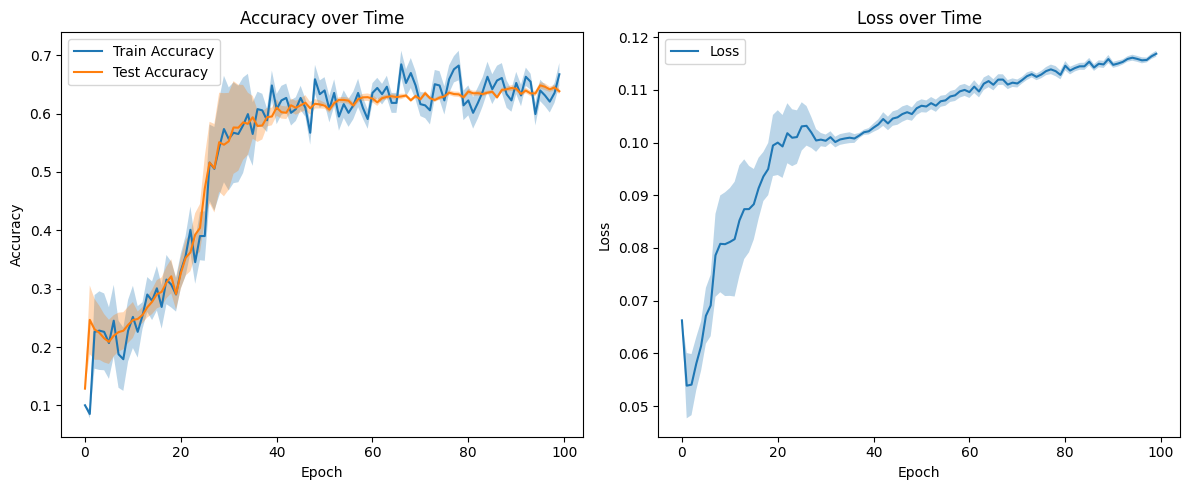

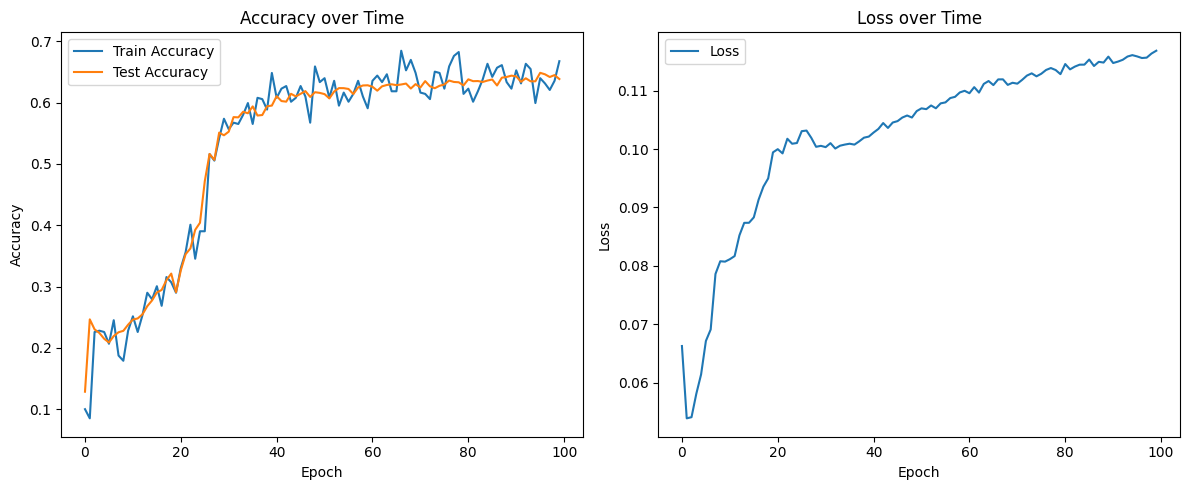

Final Train Accuracy: 0.67 ± 0.02
Final Test Accuracy: 0.64 ± 0.00


In [15]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 8,
    "grid": 3,
    "method": "KAN",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 8,
    "num_conv_layers": 3,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": False,
    "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

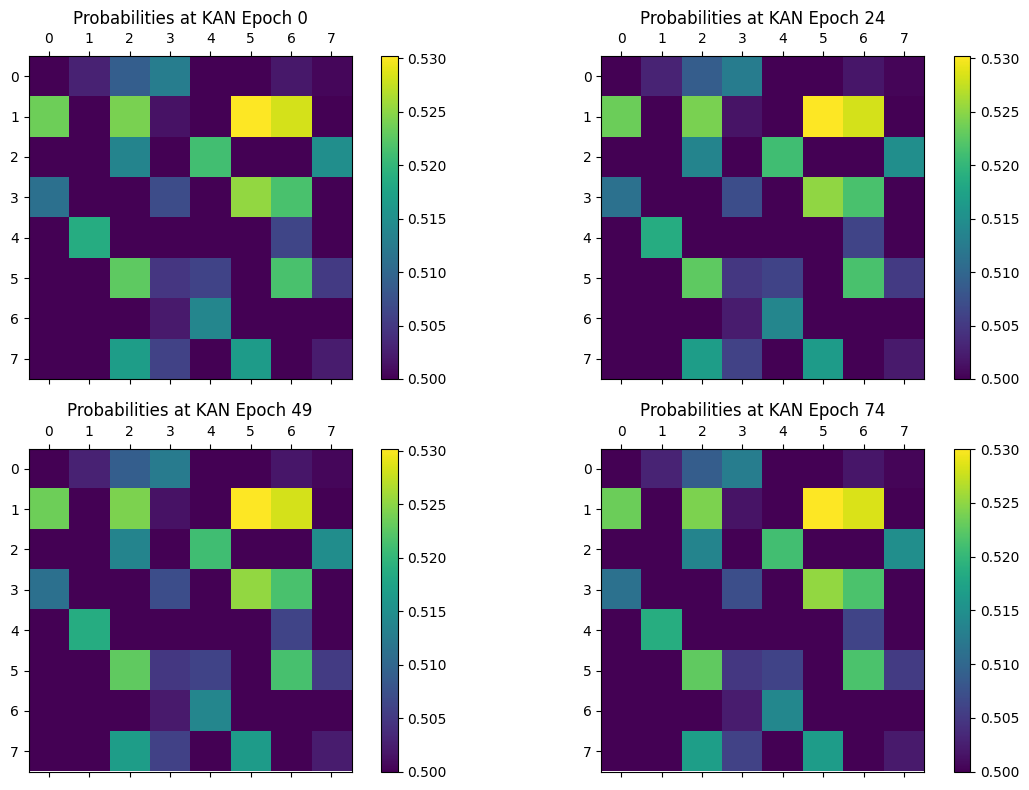

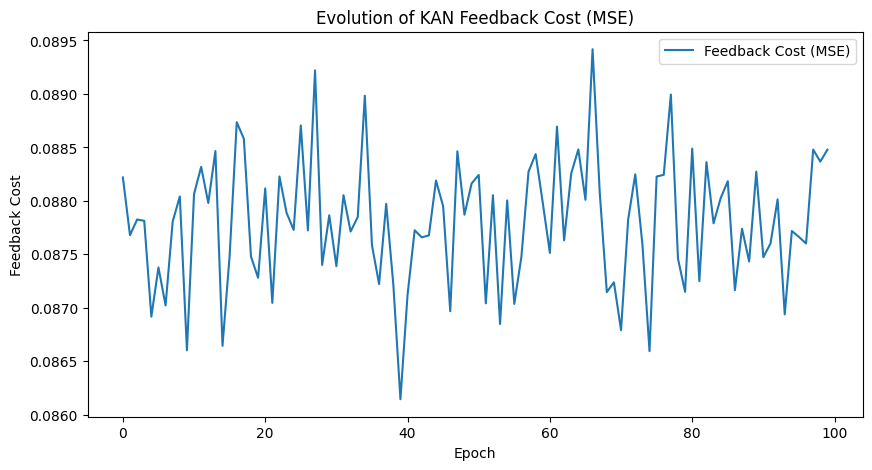

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(probs_history, feedback_cost_history, epochs=[0, 24, 49, 74], input_shape=(1, 8, 8)):
    # Determine the side length of the image
    side_length = int(np.sqrt(probs_history[0].shape[1]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for i, epoch in enumerate(epochs):
        ax = axes[i // 2, i % 2]
        if epoch < len(probs_history):
            probs = probs_history[epoch].flatten()
            if side_length ** 2 != probs.shape[0]:
                continue
            probs_image = probs.reshape((side_length, side_length))
            cax = ax.matshow(probs_image, cmap='viridis')
            fig.colorbar(cax, ax=ax)
            ax.set_title(f'Probabilities at KAN Epoch {epoch}')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(feedback_cost_history, label='Feedback Cost (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Feedback Cost')
    plt.title('Evolution of KAN Feedback Cost (MSE)')
    plt.legend()
    plt.show()


plot_evolution(probs_history, feedback_cost_history)


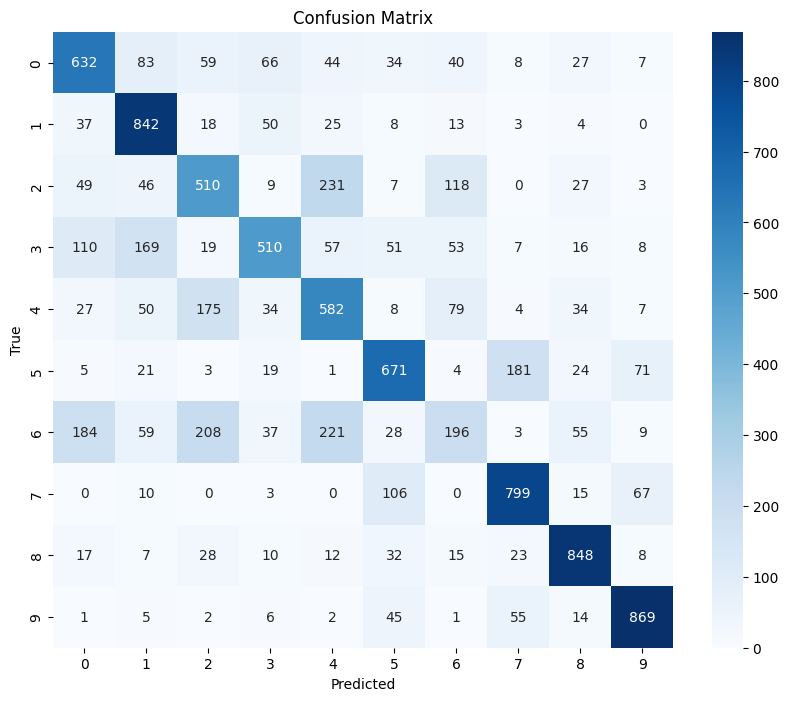

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
      # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
      # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
      # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
      # transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970)), # SVHN
    for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                                                    #split='test', download=True, transform=transforms.Compose([
                                                 #train=False, download=True, transform=transforms.Compose([
      transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
      #transforms.Grayscale(num_output_channels=1)
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)
        
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.63      0.61      1000
           1       0.65      0.84      0.73      1000
           2       0.50      0.51      0.50      1000
           3       0.69      0.51      0.58      1000
           4       0.50      0.58      0.54      1000
           5       0.68      0.67      0.67      1000
           6       0.38      0.20      0.26      1000
           7       0.74      0.80      0.77      1000
           8       0.80      0.85      0.82      1000
           9       0.83      0.87      0.85      1000

    accuracy                           0.65     10000
   macro avg       0.63      0.65      0.63     10000
weighted avg       0.63      0.65      0.63     10000



In [19]:
%load_ext tensorboard
%tensorboard --logdir runs

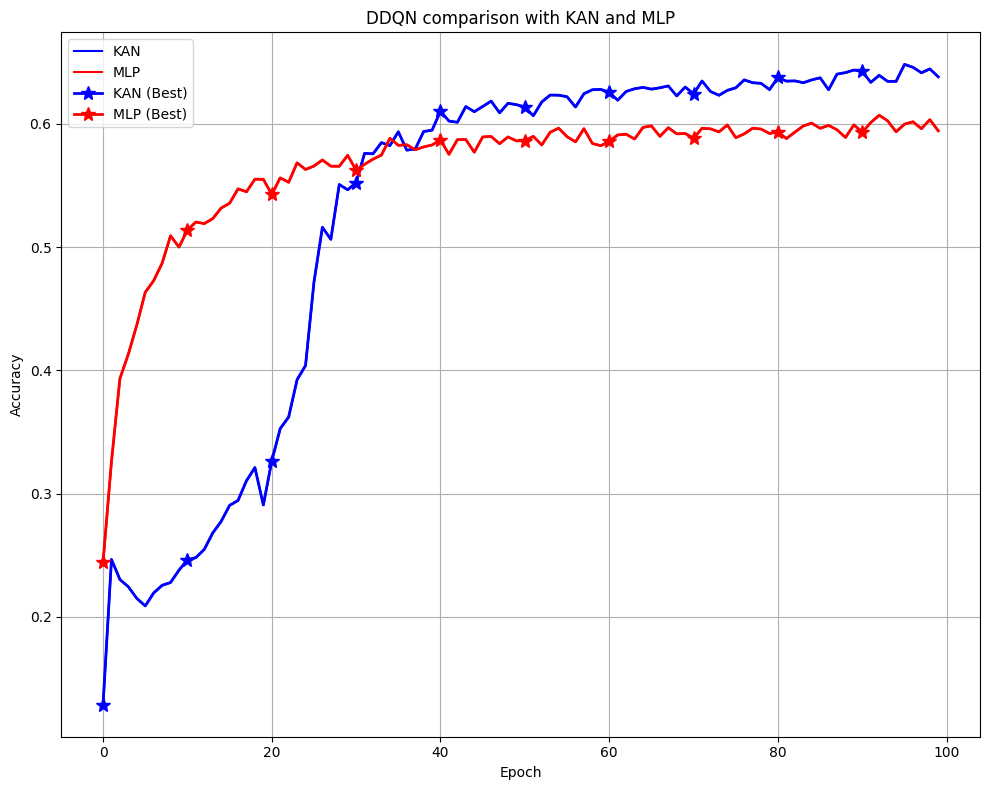

In [20]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import glob


algo1, algo2 = 'KAN', 'MLP'

files_algo1 = glob.glob(f"/kaggle/working/results/{algo1}_*.csv")
files_algo2 = glob.glob(f"/kaggle/working/results/{algo2}_*.csv")

df_algo1 = pd.concat((pd.read_csv(file) for file in files_algo1))
df_algo2 = pd.concat((pd.read_csv(file) for file in files_algo2))

median_algo1 = df_algo1.groupby('epoch')['accuracy'].median()
median_algo2 = df_algo2.groupby('epoch')['accuracy'].median()
quantile_25_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.75)
quantile_25_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.25)
quantile_75_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.75)

best_algo1 = df_algo1.groupby('epoch')['accuracy'].max()
best_algo2 = df_algo2.groupby('epoch')['accuracy'].max()

plt.figure(figsize=(10, 8))

plt.plot(median_algo1.index, median_algo1, label=f"{algo1}", color='blue')
plt.fill_between(median_algo1.index, quantile_25_algo1, quantile_75_algo1, alpha=0.3, color='blue')

plt.plot(median_algo2.index, median_algo2, label=f"{algo2}", color='red')
plt.fill_between(median_algo2.index, quantile_25_algo2, quantile_75_algo2, alpha=0.3, color='red')

plt.plot(best_algo1.index, best_algo1, label=f"{algo1} (Best)", color='blue', marker='*', markersize=10, markevery=10, lw=2)

plt.plot(best_algo2.index, best_algo2, label=f"{algo2} (Best)", color='red', marker='*', markersize=10, markevery=10, lw=2)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'DDQN comparison with {algo1} and {algo2}')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


In [21]:
import gc
gc.collect()

56995

In [22]:
# q_network.prune()

In [23]:
# q_network.plot(beta=30, scale=1, out_vars=[0,1,2,3,4,5,6,7,8,9])

In [24]:
# lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
# q_network.auto_symbolic(lib=lib)

In [25]:
# symbolic_formula = f"### The symbolic formula of the policy is:"
# formulas = q_network.symbolic_formula()[0]

In [26]:
# from sympy import latex
# import glob
# import os

# import gymnasium as gym
# import numpy as np
# from gymnasium.wrappers import RecordVideo
# from moviepy.video.compositing.concatenate import concatenate_videoclips
# from moviepy.video.io.VideoFileClip import VideoFileClip
# from sympy import latex
# import matplotlib.pyplot as plt


# for i, formula in enumerate(formulas):
#     symbolic_formula += "\n$$ a_" + str(i) + "=" + latex(formula) + "$$"
# symbolic_formula += "\n" + r"$$ a = \underset{i}{\mathrm{argmax}} \ a_i.$$"

In [27]:
# print(symbolic_formula)

In [28]:
# formulas[0] # formula of a_0

In [29]:
# print(formulas[0])

In [30]:
# formulas

In [31]:
# import re
# from collections import Counter
# import matplotlib.pyplot as plt

# # Given symbolic formula (abbreviated for clarity)
# formula = str(formulas)

# # Extract all feature occurrences
# features = re.findall(r'x_\d+', formula)

# # Count feature occurrences
# feature_counts = Counter(features)

# # Extract coefficients for the features
# coefficients = re.findall(r'([+-]?\d*\.?\d+)\*?x_\d+', formula)
# coefficients = [float(c) for c in coefficients]

# # Combine frequency and coefficient magnitude for importance
# feature_importance = {}
# for feature in feature_counts:
#     feature_importance[feature] = feature_counts[feature]

# # Sort features by importance
# sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

# # Plotting feature importance
# features, importance = zip(*sorted_features)
# plt.figure(figsize=(12, 8))
# plt.bar(features, importance)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Feature Importance')
# plt.xticks(rotation=90)
# plt.show()


In [32]:
# import re
# from collections import Counter
# import matplotlib.pyplot as plt

# def parse_formula(formula):
#     # Extract all feature occurrences
#     features = re.findall(r'x_\d+', formula)
#     # Extract coefficients for the features
#     coefficients = re.findall(r'([+-]?\d*\.?\d+)\*?x_\d+', formula)
#     coefficients = [float(c) for c in coefficients]
#     return features, coefficients

# def compute_feature_importance(features, coefficients):
#     # Count feature occurrences
#     feature_counts = Counter(features)
#     # Combine frequency and coefficient magnitude for importance
#     feature_importance = {}
#     for feature in feature_counts:
#         feature_importance[feature] = feature_counts[feature]
#     return feature_importance

# # Plot feature importance for each component
# fig, axes = plt.subplots(5, 2, figsize=(15, 25))
# axes = axes.flatten()

# for i, formula in enumerate(formulas):
#     features, coefficients = parse_formula(str(formula))
#     feature_importance = compute_feature_importance(features, coefficients)

#     # Sort features by importance
#     sorted_features = sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)

#     # Plotting feature importance
#     features, importance = zip(*sorted_features)
#     axes[i].bar(features, importance)
#     axes[i].set_xlabel('Features')
#     axes[i].set_ylabel('Importance')
#     axes[i].set_title(f'Feature Importance for a_{i}')
#     axes[i].tick_params(axis='x', rotation=90)

# plt.tight_layout()
# plt.show()


First Part: Activation Functions for the Middle Neurons in the First Hidden Layer

Objective: Plot activation functions for the middle neurons in the first hidden layer.
Setup: A 2x6 grid (2 rows, 6 columns) for plotting.
Loop: Iterate over input neurons (i = 0 and i = 1) and middle neurons (j = 0 to 5).
Layer: l = 1 corresponds to the first hidden layer.
Extraction: Extract spline_preacts and spline_postacts for the specified neurons.
Sorting: Sort inputs and corresponding outputs for better visualization.
Plotting: Plot the activation function for each combination in the grid.

In [33]:
# # Create a 2x6 grid for plotting (2 rows, 6 columns)
# fig, axs = plt.subplots(8, 2, figsize=(10, 35))
# middle_neurons = [0, 1, 2, 3, 4, 5, 6, 7]  # Output neurons in the first hidden layer
# input_neurons = [0, 1]

# model = q_network

# for row, i in enumerate(middle_neurons):  # Input neurons i = 0 and i = 1
#     for col, j in enumerate(input_neurons):
#         l = 1  # Layer index (first hidden layer)

#         # Extract inputs and outputs of the spline activation functions
#         inputs = model.spline_preacts[l][:, i, j]
#         outputs = model.spline_postacts[l][:, i, j]

#         # Sort the inputs and corresponding outputs for plotting
#         rank = np.argsort(inputs)
#         inputs = inputs[rank]
#         outputs = outputs[rank]

#         # Determine subplot location
#         ax = axs[row, col]

#         # Plot the activation function
#         ax.plot(inputs, outputs, marker="o")
#         ax.set_title(f'Activation Function\nLayer {l}, Input Neuron {i}, Output Neuron {j}')
#         ax.set_xlabel('Input')
#         ax.set_ylabel('Output')
#         ax.grid(True)

# plt.tight_layout(pad=3)
# plt.show()


Second Part: Activation Functions Between the First Hidden Layer and the Output Layer

Objective: Plot activation functions for the neurons between the first hidden layer and the output layer.
Setup: A 6x2 grid (6 rows, 2 columns) for plotting.
Loop: Iterate over hidden neurons (i = 0 to 5) and output neurons (j = 0 and j = 1).
Layer: l = 1 corresponds to the output layer.
Extraction: Extract spline_preacts and spline_postacts for the specified neurons.
Sorting: Sort inputs and corresponding outputs for better visualization.
Plotting: Plot the activation function for each combination in the grid.

In [34]:
# # Extract and plot activation functions for the neurons between the first hidden layer and the output layer
# hidden_neurons = [0, 1, 2, 3, 4, 5, 6, 7]  # Neurons in the first hidden layer
# output_neurons = [0, 1]  # Neurons in the output layer

# # Create a 3x2 grid for plotting
# fig, axs = plt.subplots(8, 2, figsize=(10, 35))

# for row, i in enumerate(hidden_neurons):  # Neurons in the first hidden layer
#     for col, j in enumerate(output_neurons):  # Neurons in the output layer
#         l = 1  # Layer index (output layer)

#         # Extract inputs and outputs of the spline activation functions
#         inputs = model.spline_preacts[l][:, j, i]
#         outputs = model.spline_postacts[l][:, j, i]

#         # Sort the inputs and corresponding outputs for plotting
#         rank = np.argsort(inputs)
#         inputs = inputs[rank]
#         outputs = outputs[rank]

#         # Determine subplot location
#         ax = axs[row, col]

#         # Plot the activation function
#         ax.plot(inputs, outputs, marker="o")
#         ax.set_title(f'Activation Function\nLayer {l}, Hidden Neuron {i}, Output Neuron {j}')
#         ax.set_xlabel('Input')
#         ax.set_ylabel('Output')
#         ax.grid(True)

# # Add space between subplots
# plt.tight_layout(pad=3.0)
# plt.show()

# Tensorboard

In [35]:
# %load_ext tensorboard
# %tensorboard --logdir runs

In [36]:
# import gc
# gc.collect()

In [37]:
# import sys
# import pandas as pd
# import matplotlib.pyplot as plt
# import glob


# algo1, algo2 = 'KAN', 'MLP'

# files_algo1 = glob.glob(f"/kaggle/working/results/{algo1}_*.csv")
# files_algo2 = glob.glob(f"/kaggle/working/results/{algo2}_*.csv")

# df_algo1 = pd.concat((pd.read_csv(file) for file in files_algo1))
# df_algo2 = pd.concat((pd.read_csv(file) for file in files_algo2))

# median_algo1 = df_algo1.groupby('epoch')['accuracy'].median()
# median_algo2 = df_algo2.groupby('epoch')['accuracy'].median()
# quantile_25_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.25)
# quantile_75_algo1 = df_algo1.groupby('epoch')['accuracy'].quantile(0.75)
# quantile_25_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.25)
# quantile_75_algo2 = df_algo2.groupby('epoch')['accuracy'].quantile(0.75)

# best_algo1 = df_algo1.groupby('epoch')['accuracy'].max()
# best_algo2 = df_algo2.groupby('epoch')['accuracy'].max()

# plt.figure(figsize=(10, 8))

# plt.plot(median_algo1.index, median_algo1, label=f"{algo1}", color='blue')
# plt.fill_between(median_algo1.index, quantile_25_algo1, quantile_75_algo1, alpha=0.3, color='blue')

# plt.plot(median_algo2.index, median_algo2, label=f"{algo2}", color='red')
# plt.fill_between(median_algo2.index, quantile_25_algo2, quantile_75_algo2, alpha=0.3, color='red')

# plt.plot(best_algo1.index, best_algo1, label=f"{algo1} (Best)", color='blue', marker='*', markersize=10, markevery=10, lw=2)

# plt.plot(best_algo2.index, best_algo2, label=f"{algo2} (Best)", color='red', marker='*', markersize=10, markevery=10, lw=2)

# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title(f'DDQN comparison with {algo1} and {algo2}')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# plt.show()


In [38]:
# from google.colab import files
# files.download('/content/results/KAN_MNIST_0_1720304363.csv')

In [39]:
# import matplotlib.pyplot as plt
# from sympy import symbols, lambdify, exp, sin, cos, log, sqrt, tan
# import numpy as np

# # Define 10 symbolic variables
# x_symbols = symbols('x_1:11')  # x_1, x_2, ..., x_10

# # Example list of 10 formulas, each involving the 10 variables
# # formulas = [
# #     0.5*x_symbols[0] + 0.3*x_symbols[1]**2 - 0.2*x_symbols[2] + 0.1*x_symbols[3]**2,
# #     exp(0.5*x_symbols[4]) - 0.8*sin(x_symbols[5]) + 0.3*cos(x_symbols[6]),
# #     log(x_symbols[7] + 2) + sqrt(abs(x_symbols[8])) - 0.4*x_symbols[9],
# #     0.2*x_symbols[0]**3 - 0.3*sin(x_symbols[1]) + 0.7*x_symbols[2]**2 + cos(x_symbols[3]),
# #     sinh(x_symbols[4]) - cosh(x_symbols[5]) + 0.5*x_symbols[6]**2,
# #     tan(x_symbols[7]) + 0.1*log(x_symbols[8] + 1) - 0.2*x_symbols[9]**2,
# #     exp(-0.5*x_symbols[0]) + 0.3*x_symbols[1]**3 - 0.7*x_symbols[2] + sqrt(x_symbols[3] + 4),
# #     0.4*sin(x_symbols[4]) + 0.6*cos(x_symbols[5] + x_symbols[6]**2) - 0.2*tan(x_symbols[7]),
# #     log(x_symbols[8] + 3) + exp(x_symbols[9]) - 0.1*x_symbols[0] + 0.3*x_symbols[1],
# #     sinh(x_symbols[2]) + cosh(x_symbols[3] - 1) - sin(x_symbols[4]) + 0.5*x_symbols[5]**2
# # ]

# # Generate values for the variables
# x_values = np.linspace(-2, 2, 400)  # Values for the variable being varied
# fixed_values = [0] * 10  # Initial fixed values for the other variables

# # Set up subplots
# fig, axes = plt.subplots(5, 2, figsize=(12, 20))  # 5x2 grid of subplots
# axes = axes.flatten()  # Flatten the axes array for easy indexing

# # Plot each variable's influence in its own subplot
# for i in range(len(x_symbols)):
#     axes[i].set_title(f'Effect of {x_symbols[i]} on the formulas', fontsize=14)
#     axes[i].set_xlabel(f'{x_symbols[i]}', fontsize=12)
#     axes[i].set_ylabel('f(x)', fontsize=12)
    
#     # Iterate through each formula
#     for j, formula in enumerate(formulas):
#         # Lambdify the current formula with all 10 variables
#         f = lambdify(x_symbols, formula, "numpy")
        
#         # Compute y values for varying the i-th variable
#         y_values = []
#         for val in x_values:
#             current_values = fixed_values.copy()  # Start with fixed values
#             current_values[i] = val  # Vary the i-th variable
#             y_values.append(f(*current_values))
        
#         # Plot the function corresponding to the j-th formula
#         axes[i].plot(x_values, y_values, label=f"$a_{j}$")
    
#     axes[i].grid(True)
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig('10_formulas_plot.png', dpi=300)
# plt.show()


https://daniel-bethell.co.uk/posts/mccp/

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# Paper codes